In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler  
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, classification_report, average_precision_score, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [33]:
date_columns = ["Timestamp"]
df = pd.read_csv("ddos_dataset.csv", parse_dates=date_columns,index_col=None)
df.head()

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,2018-02-22 00:27:57,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,2018-02-16 23:18:14,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,2018-02-16 23:23:20,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,2018-02-16 23:22:41,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,2018-02-21 23:49:25,233.750000,233.750000,-1,32768,0,ddos


In [34]:
df.head(3)

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,2018-02-22 00:27:57,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,2018-02-16 23:18:14,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,2018-02-16 23:23:20,114.333333,114.333333,-1,219,0,ddos


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Flow ID            500000 non-null  object        
 1   Timestamp          500000 non-null  datetime64[ns]
 2   Fwd Pkt Len Mean   500000 non-null  float64       
 3   Fwd Seg Size Avg   500000 non-null  float64       
 4   Init Fwd Win Byts  500000 non-null  int64         
 5   Init Bwd Win Byts  500000 non-null  int64         
 6   Fwd Seg Size Min   500000 non-null  int64         
 7   Label              500000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 30.5+ MB


In [36]:
df[['Source', 'Destination', 'Source Port', 'Dest Port', 'Other']] = df['Flow ID'].str.split('-', expand=True)
df.head()

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,Source,Destination,Source Port,Dest Port,Other
0,172.31.69.28-18.216.200.189-80-52169-6,2018-02-22 00:27:57,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.216.200.189,80,52169,6
1,172.31.69.25-18.219.193.20-80-44588-6,2018-02-16 23:18:14,0.000000,0.000000,-1,225,0,ddos,172.31.69.25,18.219.193.20,80,44588,6
2,172.31.69.25-18.219.193.20-80-43832-6,2018-02-16 23:23:20,114.333333,114.333333,-1,219,0,ddos,172.31.69.25,18.219.193.20,80,43832,6
3,172.31.69.25-18.219.193.20-80-53346-6,2018-02-16 23:22:41,233.750000,233.750000,-1,211,0,ddos,172.31.69.25,18.219.193.20,80,53346,6
4,172.31.69.28-18.218.55.126-80-57856-6,2018-02-21 23:49:25,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.218.55.126,80,57856,6


In [37]:
df.loc[:,'Label'].unique()

array(['ddos', 'Benign'], dtype=object)

In [38]:
df = df.sort_values("Timestamp")

In [39]:
df

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,Source,Destination,Source Port,Dest Port,Other
13318,192.168.1.104-203.73.24.75-19754-80-6,2010-06-13 00:12:59,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75,19754,80,6
21539,192.168.1.104-203.73.24.75-19817-80-6,2010-06-13 00:13:30,45.500000,45.500000,-1,5840,0,ddos,192.168.1.104,203.73.24.75,19817,80,6
87259,192.168.1.104-203.73.24.75-19824-80-6,2010-06-13 00:13:34,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75,19824,80,6
61071,192.168.1.104-203.73.24.75-19830-80-6,2010-06-13 00:13:37,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75,19830,80,6
5143,192.168.1.104-203.73.24.75-19881-80-6,2010-06-13 00:14:07,39.333333,39.333333,-1,5840,0,ddos,192.168.1.104,203.73.24.75,19881,80,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98633,172.31.69.28-18.216.200.189-80-63226-6,2018-02-22 00:35:49,0.000000,0.000000,-1,32738,0,ddos,172.31.69.28,18.216.200.189,80,63226,6
98945,172.31.69.28-18.216.200.189-80-63277-6,2018-02-22 00:35:51,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.216.200.189,80,63277,6
17333,172.31.69.28-18.216.200.189-80-63293-6,2018-02-22 00:35:52,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.216.200.189,80,63293,6
97069,172.31.69.28-18.216.200.189-80-63303-6,2018-02-22 00:35:53,0.000000,0.000000,-1,32738,0,ddos,172.31.69.28,18.216.200.189,80,63303,6


In [40]:
df = df.drop(columns=["Timestamp", "Source Port", "Dest Port", "Other"])
df.head()

,Flow ID,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,Source,Destination
13318,192.168.1.104-203.73.24.75-19754-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
21539,192.168.1.104-203.73.24.75-19817-80-6,45.500000,45.500000,-1,5840,0,ddos,192.168.1.104,203.73.24.75
87259,192.168.1.104-203.73.24.75-19824-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
61071,192.168.1.104-203.73.24.75-19830-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
5143,192.168.1.104-203.73.24.75-19881-80-6,39.333333,39.333333,-1,5840,0,ddos,192.168.1.104,203.73.24.75


In [41]:
df[['SourceIP_1', 'SourceIP_2', 'SourceIP_3', 'SourceIP_4']] = df.Source.str.split('.', expand=True)
df[['DestinationIP_1', 'DestinationIP_2', 'DestinationIP_3', 'DestinationIP_4']] = df.Destination.str.split('.', expand=True)
df = df.drop(columns=["Source", "Destination", "Flow ID"])
df.head()

,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,SourceIP_1,SourceIP_2,SourceIP_3,SourceIP_4,DestinationIP_1,DestinationIP_2,DestinationIP_3,DestinationIP_4
13318,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
21539,45.500000,45.500000,-1,5840,0,ddos,192,168,1,104,203,73,24,75
87259,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
61071,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
5143,39.333333,39.333333,-1,5840,0,ddos,192,168,1,104,203,73,24,75


In [42]:
df.isna().sum()

Fwd Pkt Len Mean     0
Fwd Seg Size Avg     0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Seg Size Min     0
Label                0
SourceIP_1           0
SourceIP_2           0
SourceIP_3           0
SourceIP_4           0
DestinationIP_1      0
DestinationIP_2      0
DestinationIP_3      0
DestinationIP_4      0
dtype: int64

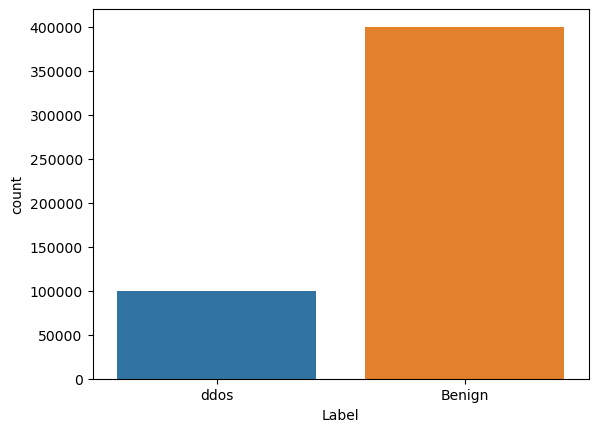

In [43]:
sns.countplot(data =df , x="Label");

In [44]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head()

,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,SourceIP_1,SourceIP_2,SourceIP_3,SourceIP_4,DestinationIP_1,DestinationIP_2,DestinationIP_3,DestinationIP_4
13318,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
21539,45.500000,45.500000,-1,5840,0,1,192,168,1,104,203,73,24,75
87259,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
61071,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
5143,39.333333,39.333333,-1,5840,0,1,192,168,1,104,203,73,24,75


In [45]:
X = df.drop('Label' , axis = 1)
y = df['Label']
RUS = RandomUnderSampler(random_state=42)
X_rus, y_rus = RUS.fit_resample(X,y)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.3, random_state=42)

In [47]:
models = {"Logistic Regression": LogisticRegression(), "Random Forest": RandomForestClassifier(),
         "KNN": KNeighborsClassifier(), "AdaBoost": AdaBoostClassifier()}

cv = KFold(n_splits=10)
import time

def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    model_roc_auc_scores = {}
    model_time = {}
    for name, model in models.items():
        start = time.process_time()
        model.fit(X_train, y_train)
        model_time[name] = time.process_time() - start
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        model_roc_auc_scores[name] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        model_scores[name] = model.score(X_test, y_test)
    return model_scores, model_roc_auc_scores, model_time

In [48]:
model_scores, model_roc_auc_scores, model_time = fit_and_score(models, X_train, X_test, y_train, y_test)
print("ACCURACIES : ")
model_scores

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ACCURACIES : 


{'Logistic Regression': 0.9573333333333334,
 'Random Forest': 0.9999666666666667,
 'KNN': 0.9987833333333334,
 'AdaBoost': 0.9997}

In [49]:
print("ROC AUC SCORES : ")
model_roc_auc_scores

ROC AUC SCORES : 


{'Logistic Regression': 0.9905070247182843,
 'Random Forest': 0.9999999372206736,
 'KNN': 0.9996129115624995,
 'AdaBoost': 0.9999994033186146}

In [50]:
print("Time : ")
model_time

Time : 


{'Logistic Regression': 4.203125,
 'Random Forest': 8.28125,
 'KNN': 1.53125,
 'AdaBoost': 46.828125}

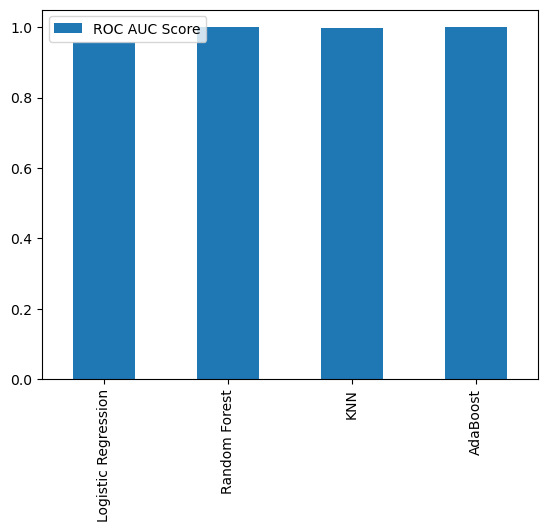

In [51]:
model_compare = pd.DataFrame(model_scores, index=['ROC AUC Score'])
model_compare.T.plot.bar();

In [52]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9999666666666667

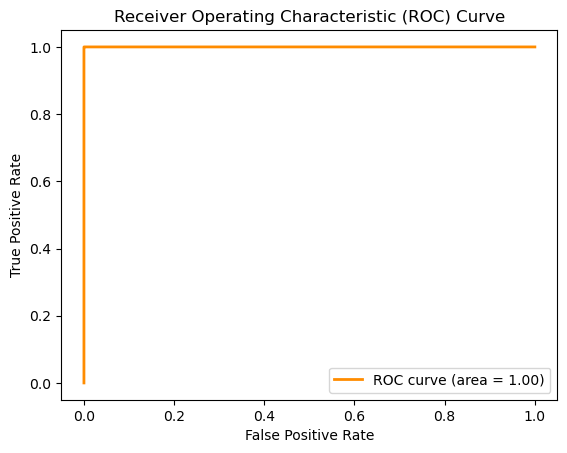

In [61]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


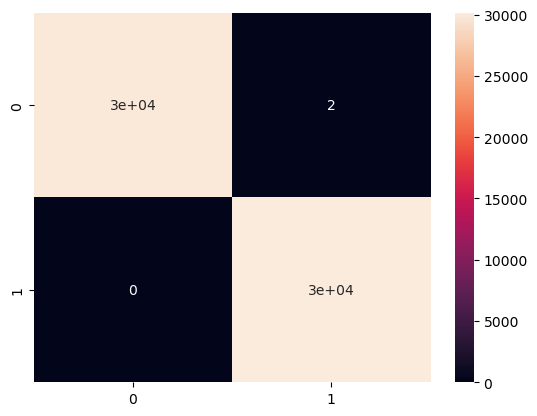

In [59]:
y_preds = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_mat, annot=True);

In [60]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29851
           1       1.00      1.00      1.00     30149

    accuracy                           1.00     60000
   macro avg       1.00      1.00      1.00     60000
weighted avg       1.00      1.00      1.00     60000

